In [13]:
%load_ext autoreload
%autoreload 2

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# from torch.utils.data import Dataset, DataLoader
# import segmentation_models_pytorch as smp
# import numpy as np
# from PIL import Image
# import re
# from skimage.transform import resize
# print(tf.config.list_physical_devices('GPU'))

# # from tensorflow.keras.models import Sequential, Model, load_model

import os

import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, KFold

import pandas as pd

# # from tensorflow.keras.optimizers import Adam
# # from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from src.custom_dataset import CustomDataset
from src.model_unet import ModelUnet
from src.model_trainer import ModelTrainer



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Preparing dataset

In [3]:
dataset_images_dir = "../Data/Tool_dataset/images/"
dataset_masks_dir = "../Data/Tool_dataset/masks/" 
dataset_binary_masks_dir = "../Data/Tool_dataset/binary_masks/"

dataset = CustomDataset(dataset_images_dir, dataset_masks_dir, dataset_binary_masks_dir)

Image shape:  (1144, 2392, 3)
Mask shape:  (1144, 2392)


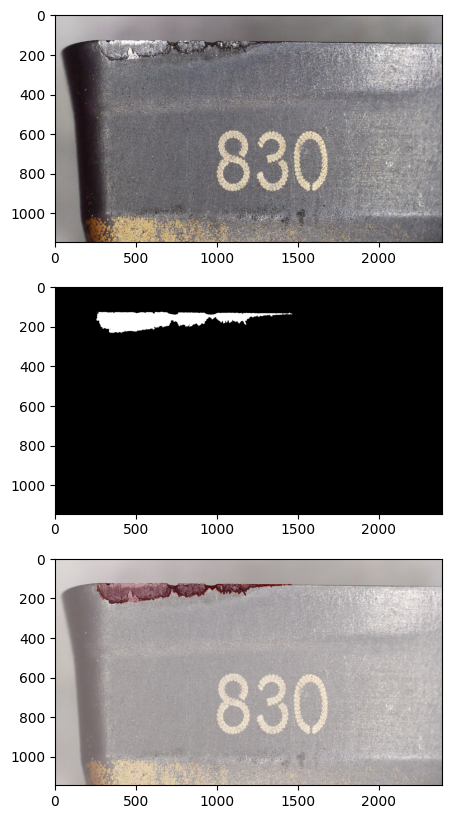

In [4]:
CustomDataset.image_display(dataset.image_paths, dataset.binary_mask_paths, 100)

#### 2. Data Preprocess: Data Augmentation

In [5]:
aug_images = dataset.image_paths
aug_masks = dataset.binary_mask_paths

train_dataframe = CustomDataset.create_df(dataset.image_paths, dataset.binary_mask_paths)
df = train_dataframe
display(df)

,filename,mask
0,../Data/Tool_dataset/images/11_6_1.png,../Data/Tool_dataset/binary_masks/11_6_1_mask.png
1,../Data/Tool_dataset/images/12_7_2.png,../Data/Tool_dataset/binary_masks/12_7_2_mask.png
2,../Data/Tool_dataset/images/13_6_2.png,../Data/Tool_dataset/binary_masks/13_6_2_mask.png
3,../Data/Tool_dataset/images/13_2_4.png,../Data/Tool_dataset/binary_masks/13_2_4_mask.png
4,../Data/Tool_dataset/images/13_2_2.png,../Data/Tool_dataset/binary_masks/13_2_2_mask.png
...,...,...
101,../Data/Tool_dataset/images/11_4_1.png,../Data/Tool_dataset/binary_masks/11_4_1_mask.png
102,../Data/Tool_dataset/images/13_1_3.png,../Data/Tool_dataset/binary_masks/13_1_3_mask.png
103,../Data/Tool_dataset/images/10_4_3.png,../Data/Tool_dataset/binary_masks/10_4_3_mask.png
104,../Data/Tool_dataset/images/13_3_4.png,../Data/Tool_dataset/binary_masks/13_3_4_mask.png


##### Data Augmentation

In [7]:
train_generator_args = dict(rotation_range=0.15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

height = 256
width = 256
channel = 3

# To visualize the results of generator: set save_to_dir = "your path"
aug_img_dir = "../Data/Tool_dataset/augmented_images/"
aug_mask_dir = "../Data/Tool_dataset/augmented_masks/"
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_mask_dir, exist_ok=True)
aug_img_prefix = "aug_"
aug_mask_prefix = "aug_"
aug_format = "png"

#### 3. Transfer Learning with UNet

In [9]:
input_shape = (height, width, channel)
K.clear_session()
unet_model = ModelUnet.TL_unet_model(input_shape)

2025-04-22 07:48:43.808699: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
(None, 256, 256, 1)


In [10]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,854,657 (98.63 MB)

 Trainable params: 11,139,969 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
layers = [(layer, layer.name, layer.trainable) for layer in unet_model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(unet_model_df)

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer, built=True>",input_layer,False
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,False
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,False
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,False
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,False
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,False
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,False
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,False
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,False
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,False


#### Training the transfer learning U-Net Model

In [14]:
kf = KFold(n_splits=5, shuffle=True)
for k, (train_index, text_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[text_index]

print("Training dataset:")
display(train_df)
print
print("Validation and testing dataset:")
display(test_df)    
test_df.shape

Training dataset:


,filename,mask
0,../Data/Tool_dataset/images/11_6_1.png,../Data/Tool_dataset/binary_masks/11_6_1_mask.png
3,../Data/Tool_dataset/images/13_2_4.png,../Data/Tool_dataset/binary_masks/13_2_4_mask.png
4,../Data/Tool_dataset/images/13_2_2.png,../Data/Tool_dataset/binary_masks/13_2_2_mask.png
5,../Data/Tool_dataset/images/14_2_3.png,../Data/Tool_dataset/binary_masks/14_2_3_mask.png
6,../Data/Tool_dataset/images/11_1_4.png,../Data/Tool_dataset/binary_masks/11_1_4_mask.png
...,...,...
100,../Data/Tool_dataset/images/13_5_4.png,../Data/Tool_dataset/binary_masks/13_5_4_mask.png
102,../Data/Tool_dataset/images/13_1_3.png,../Data/Tool_dataset/binary_masks/13_1_3_mask.png
103,../Data/Tool_dataset/images/10_4_3.png,../Data/Tool_dataset/binary_masks/10_4_3_mask.png
104,../Data/Tool_dataset/images/13_3_4.png,../Data/Tool_dataset/binary_masks/13_3_4_mask.png


Validation and testing dataset:


,filename,mask
1,../Data/Tool_dataset/images/12_7_2.png,../Data/Tool_dataset/binary_masks/12_7_2_mask.png
2,../Data/Tool_dataset/images/13_6_2.png,../Data/Tool_dataset/binary_masks/13_6_2_mask.png
17,../Data/Tool_dataset/images/12_6_3.png,../Data/Tool_dataset/binary_masks/12_6_3_mask.png
23,../Data/Tool_dataset/images/13_6_3.png,../Data/Tool_dataset/binary_masks/13_6_3_mask.png
26,../Data/Tool_dataset/images/10_4_2.png,../Data/Tool_dataset/binary_masks/10_4_2_mask.png
29,../Data/Tool_dataset/images/10_7_1.png,../Data/Tool_dataset/binary_masks/10_7_1_mask.png
33,../Data/Tool_dataset/images/12_2_1.png,../Data/Tool_dataset/binary_masks/12_2_1_mask.png
38,../Data/Tool_dataset/images/14_4_2.png,../Data/Tool_dataset/binary_masks/14_4_2_mask.png
42,../Data/Tool_dataset/images/10_3_4.png,../Data/Tool_dataset/binary_masks/10_3_4_mask.png
49,../Data/Tool_dataset/images/11_7_3.png,../Data/Tool_dataset/binary_masks/11_7_3_mask.png


(21, 2)

#### Model training

In [15]:
batch_size = 20
epochs = 80
model_dir = "V_Unet/model_v1_real/"

history, checkpoint_path = ModelTrainer.train_model(df, train_df, test_df, unet_model, 
                    batch_size, epochs, 
                    train_generator_args,aug_img_dir, aug_mask_dir, aug_img_prefix, aug_mask_prefix, aug_format, 
                    height, width,
                    model_dir)

Model input shape: (None, 256, 256, 3)
Found 85 validated image filenames.
Found 85 validated image filenames.


x_batch shape: (20, 256, 256, 3)
y_batch shape: (20, 256, 256, 1)
Epoch 1/80


/home/bsuetcueoglu/testprojectthesis/thesistest/thesisProjectTestEnv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.1238 - dice_coef: 0.0361 - iou: 0.0184 - loss: -0.0349Found 21 validated image filenames.
Found 21 validated image filenames.

Epoch 1: val_loss improved from inf to -0.03691, saving model to V_Unet/model_v1_real/tool_dataset.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - binary_accuracy: 0.1239 - dice_coef: 0.0363 - iou: 0.0185 - loss: -0.0349 - val_binary_accuracy: 0.1362 - val_dice_coef: 0.0369 - val_iou: 0.0188 - val_loss: -0.0369
Epoch 2/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.1389 - dice_coef: 0.0416 - iou: 0.0213 - loss: -0.0401
Epoch 2: val_loss improved from -0.03691 to -0.03906, saving model to V_Unet/model_v1_real/tool_dataset.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - binary_accuracy: 0.1402 - dice_coef: 0.0421 - iou: 0.0215 - loss: -0.0402 - val_binary_accuracy: 0.1624 - val_dice_coef: 0.0391 - val_iou: 0.0199 - val_loss: -0.0391
Epoch 3/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.

In [16]:
model, metrics, histories = ModelTrainer.evaluate_model(checkpoint_path, test_df, batch_size, height, width, history)

Found 21 validated image filenames.
Found 21 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - binary_accuracy: 0.9954 - dice_coef: 0.8700 - iou: 0.7700 - loss: -0.8700
Evaluation scores from pretrained model:
Accuracy:  [('binary_accuracy', 0.9953910708427429)]
Loss:  [('loss', -0.8700472116470337)]
Dice coefficient:  [('dice_coef', 0.8700472116470337)]
IOU:  [('iou', 0.7699896693229675)]


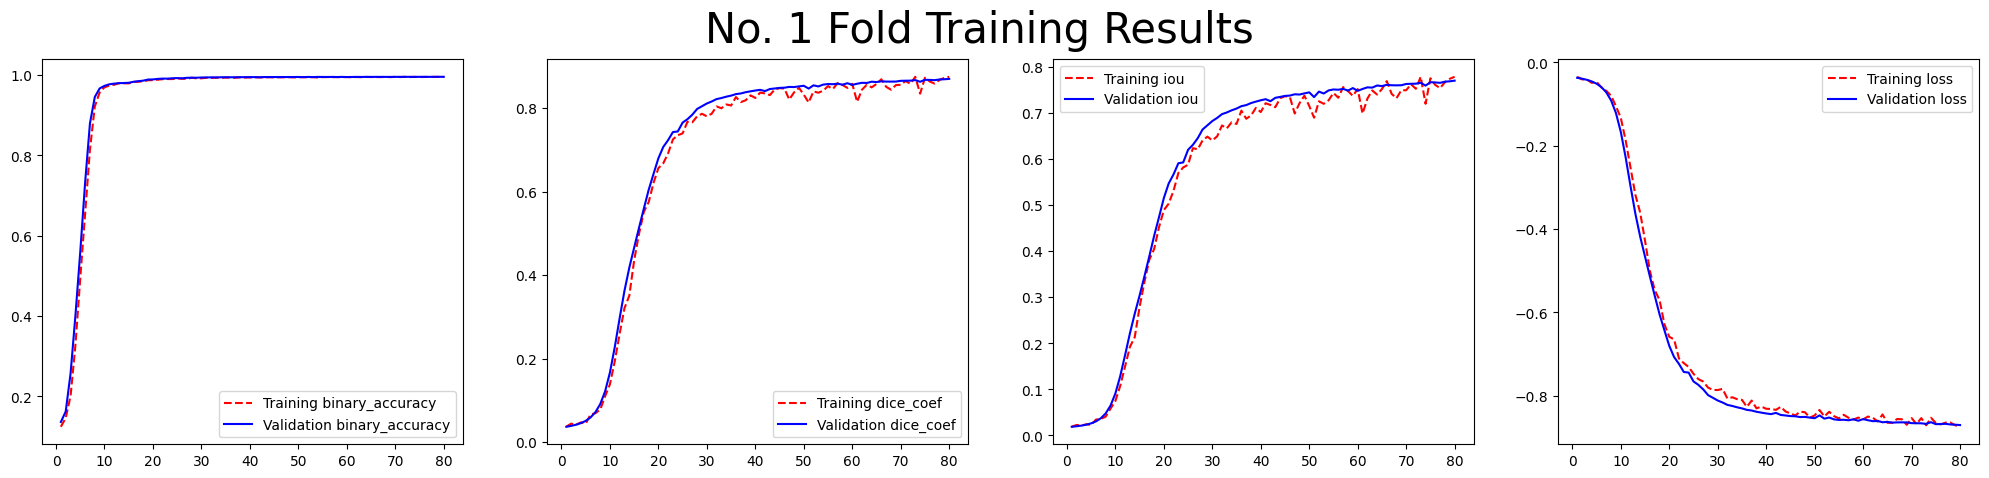

In [17]:
from src.validation_and_prediction import ValidationAndPrediction

ValidationAndPrediction.plot_histories(histories, model_dir)